# Extending `PyTorch 0.4` transforms to (image, ground-truth) pairs

In many computer vision tasks related to densepredictions (e.g. segmentation, super-resolution, colorization, etc.) data comes in the form of images and associated pixel-wise ground-truth. `PyTorch` offers lots of image transforms, but does not seem to have a ready-to-go paired transformations that equally affect an image and its related ground-truth. 

Description of existing image transform techniques:


The favored solution according to this seems to be a work-around in the main part of the code, but it is relatively straightforward to modify existing transforms to take into account the existence of ground-truth in an image format.

In [1]:
from PIL import Image

In [2]:
# load image and labels with PIL
image = Image.open('images/22_training.png') # PIL image in [0,255], 3 channels
gdt = Image.open('images/22_training_av.png') # PIL image in {0,255}, 3 channels

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def imshow_pair(im, gdt):
    # will cast to numpy, in case it gets PIL images
    f, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(np.asarray(im)),  ax[0].axis('off')
    ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')

## Example: Random Rotations
To understand the problem, let us analyze as an example the `RandomRotation` class inside `torchvision.transforms`. It contains a constructor given by:
```
def __init__(self, degrees, resample=False, expand=False, center=None):
    self.resample = resample
    self.expand = expand
    self.center = center
```
which will take a user-provided range of acceptable degrees for the rotation, and optionally a resampling filter step, a expansion operation (whether to crop the image to the same size after rotating it or to modify its size to hold the rotated image), and an option to modify the center of rotation (defaults to the center of the image). I've removed the docstring and some assertions to verify that the input is valid, for the sake of legibility.

Next, there is a `get_params` static method that will randomly generate a rotation angle out of the supplied interval:
```
@staticmethod
def get_params(degrees):
    """Get parameters for ``rotate`` for a random rotation.

    Returns:
        sequence: params to be passed to ``rotate`` for random rotation.
    """
    angle = np.random.uniform(degrees[0], degrees[1])

    return angle
```
and finally we have the `__call__` method, which actually implements the rotation by calling to `F.rotate()`, the functional implementation of the rotation, which exists on `torchvision.transforms.functional` (and has been imported `as F`):
```
def __call__(self, img):
    """
        img (PIL Image): Image to be rotated.

    Returns:
        PIL Image: Rotated image.
    """

    angle = self.get_params(self.degrees)

    return F.rotate(img, angle, self.resample, self.expand, self.center)
```        

The problem with this is that each call to `get_params` will return a randomly selected angle:

In [5]:
from torchvision import transforms
degrees=(0,180)
rotate_original = transforms.RandomRotation(degrees)

In [6]:
rotated_im = rotate_original(image)
rotated_gt = rotate_original(gdt)

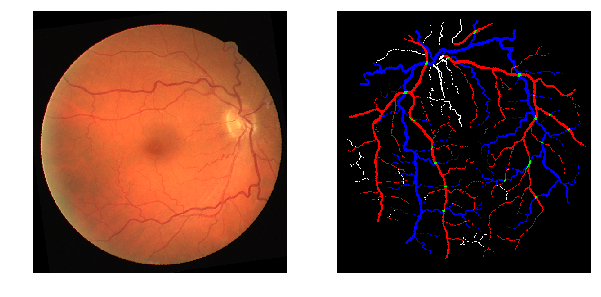

In [7]:
imshow_pair(rotated_im, rotated_gt)

This renders the transform useless for training, for instance, segmentation networks. The solution suggested [here](https://github.com/pytorch/vision/releases/tag/v0.2.0) is as follows:
```
def my_segmentation_transform(input, target):
	i, j, h, w = transforms.RandomCrop.get_params(input, (100, 100))
	input = F.crop(input, i, j, h, w)
	target = F.crop(target, i, j, h, w)
	if random.random() > 0.5:
		input = F.hflip(input)
		target = F.hflip(target)
	F.to_tensor(input), F.to_tensor(target)
	return input, target
```

An easy alternative solution is to modify the call function to accept both image and ground-truth. If ground-truth is `None`, the behavior of the modified method will be the same as above, but if it is an image, it will apply the same transform to both inputs:
```
def __call__(self, img, target = None):
    angle = self.get_params(self.degrees)
    if target is not None:
        return F.rotate(img, angle, self.resample, self.expand, self.center), \
               F.rotate(target, angle, self.resample_tg, self.expand, self.center)
               # resample = False is by default nearest, appropriate for targets

    return F.rotate(img, angle, self.resample, self.expand, self.center)
```
The trick goes as in the official suggestion above, i.e. call `get_params` once and apply the operation twice with the same parameters. We just do it inside the class, releasing the user from this work.

**Remark:** Let us note also that in this implementation there are two resampling schemes, the original `self.resample` and another one for the target, `self.resample_tg`. Often ground-truth comes in the form of images for which each color is a different label. When performing any kind of interpolation operation, we must be careful and avoid any interpolation scheme that may introduce new values that were not present before. For this reason, it's better to introduce in the constructor a separate resampling scheme, for instance Nearest Neighbors. In this particular case, False defaults to nearest, which is ok for the ground-truth image, but when working with other transforms like `RandomResizedCrop`  we should be careful and specify appropriate interpolation schemes for each image.

We can now verify that the extended functionality behaves as expected. The actual implementation of the extended routines to deal with paired transforms is in `paired_transforms_pt03.py`:

In [8]:
import paired_transforms_pt04 as p_tr
rotate_paired = p_tr.RandomRotation(degrees)

In [9]:
rotated_pair = rotate_paired(image, gdt)

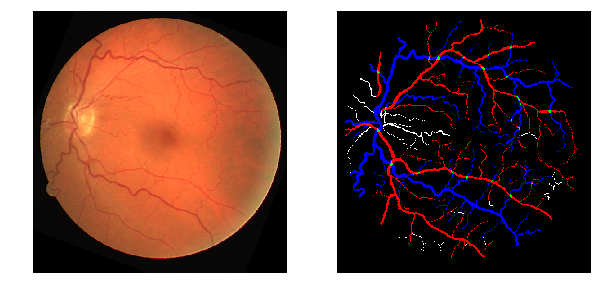

In [10]:
imshow_pair(*rotated_pair)

The nice aspect of this approach is that it is a plug-and-play implementation. You can replace in your code the `from torchvision import transforms` by `import paired_transforms as ex_tr` and it will work in exactly the same way for cases in which you pass only an image to `PyTorch` transforms. But if you pass two images, it will transform them consistenly.

I have modified every transform available in `torchvision.transforms` to accommodate for paired transforms. In the separate notebook `paired_transforms_examples.ipynb` you will find examples of all of them. I hope this is useful for someone :)